# Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [1]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading the data

In [2]:
# changed header=None to header=0, so that it automatically assigns the column names
data = pd.read_csv("adult.csv", header=0, na_values='?')
data.shape

(48842, 15)

In [3]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# observe the unique values
def get_unique_values(data):
    output_data = []
    
    for col in data.columns:
        if data.loc[:, col].nunique() <= 10:
            unique_values = data.loc[:, col].unique()
            
            output_data.append([col, data.loc[:, col].nunique(), unique_values, data.loc[:, col].dtype])
        else:
            output_data.append([col, data.loc[:, col].nunique(), "-", data.loc[:, col].dtype])
            
        output_df = pd.DataFrame(output_data, columns=['Column Name', 'Number of Unique Values', 'Unique Values ', 'Data Type'])
    
    return output_df

In [5]:
get_unique_values(data)

,Column Name,Number of Unique Values,Unique Values,Data Type
0,age,74,-,int64
1,workclass,8,"[State-gov, Self-emp-not-inc, Private, Federal...",object
2,fnlwgt,28523,-,int64
3,education,16,-,object
4,education-num,16,-,int64
5,marital-status,7,"[Never-married, Married-civ-spouse, Divorced, ...",object
6,occupation,14,-,object
7,relationship,6,"[Not-in-family, Husband, Wife, Own-child, Unma...",object
8,race,5,"[White, Black, Asian-Pac-Islander, Amer-Indian...",object
9,sex,2,"[Male, Female]",object


## Cleaning the Data

In [6]:
# Convert to categorical variables
def convert_categorical(data):
    for column in data.columns:
        if data[column].dtype == object:
            data[column] = data[column].astype('category')

In [7]:
convert_categorical(data)

In [8]:
data.dtypes

age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
salary            category
dtype: object

#### Encoding the target variable (salary)

In [9]:
# Encode the target variable
def encode_target_var(data, target_var):
    salary_mapping = {'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1}
    data[target_var] = data[target_var].map(salary_mapping)

In [10]:
# encoding the target variable
encode_target_var(data, 'salary')

In [11]:
data.sample(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
43463,38,Private,95647,HS-grad,9,Never-married,Adm-clerical,Own-child,Asian-Pac-Islander,Male,0,0,30,United-States,0
27151,36,Local-gov,298717,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,0
7898,33,Private,309630,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,0


In [12]:
# Check if the encoding went well
data['salary'].unique()

array([0, 1])

In [13]:
# Extracting numerical and categorical columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).drop(['salary'], axis=1).columns
categorical_features = data.select_dtypes(include=['category']).columns

In [14]:
# Distributions of Categorical Features
def plot_categorical_distribution(data, categorical_features):
    for column in categorical_features:
        plt.figure(figsize=(8, 6))
        ax = sns.countplot(x = column, data=data, palette='BuPu')
        plt.title(f'Distribution of Categories {column}')
        
        for container in ax.containers:
            ax.bar_label(container, rotation=90)
        
        plt.xticks(rotation=90)
        plt.show()
        
def plot_category(data, category_name):
    plt.figure(figsize=(15, 5))
    ax = sns.countplot(data=data, x=category_name, hue="salary", palette='BuPu')
    
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.show()

C:\Users\marie\AppData\Local\Temp\ipykernel_15180\2893828428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = column, data=data, palette='BuPu')


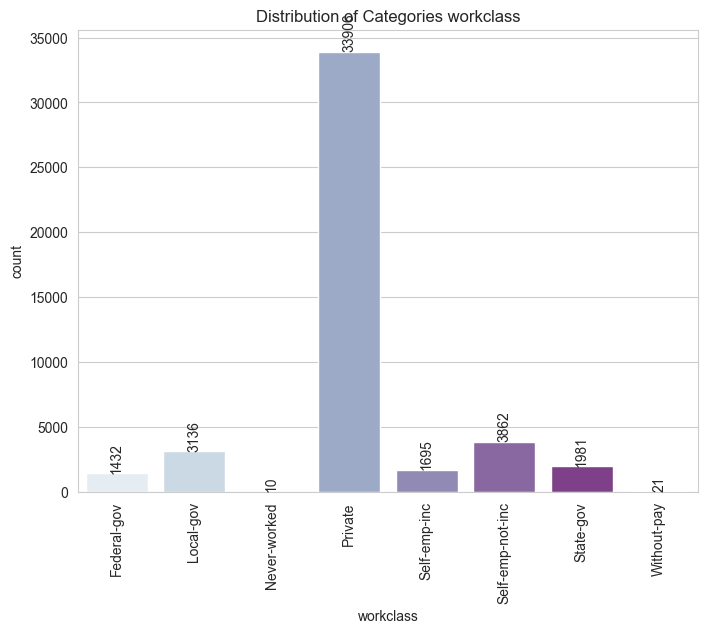

C:\Users\marie\AppData\Local\Temp\ipykernel_15180\2893828428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = column, data=data, palette='BuPu')


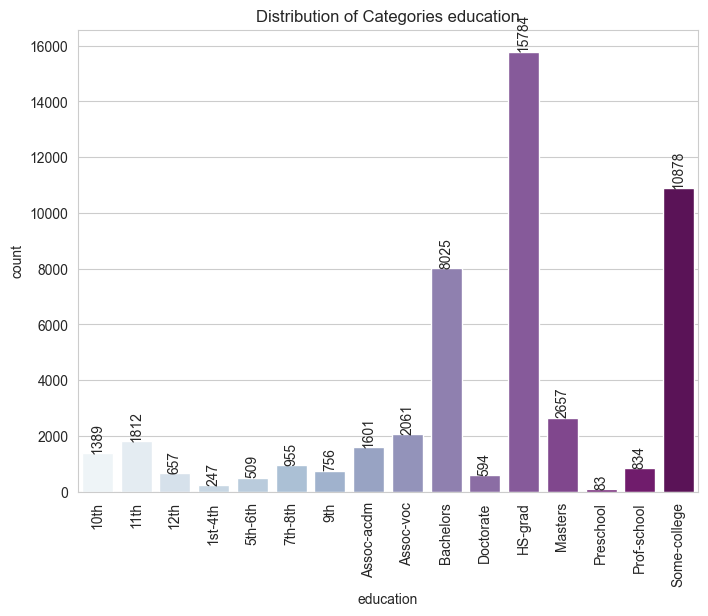

C:\Users\marie\AppData\Local\Temp\ipykernel_15180\2893828428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = column, data=data, palette='BuPu')


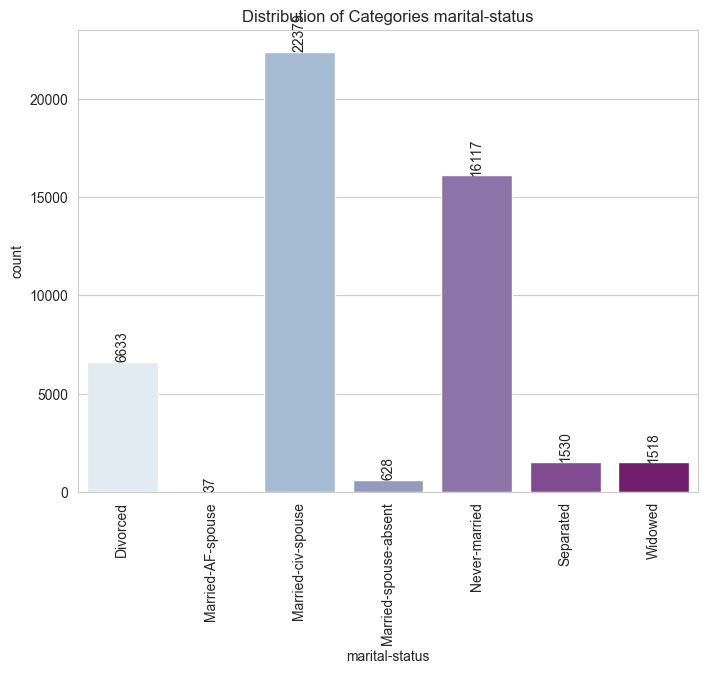

C:\Users\marie\AppData\Local\Temp\ipykernel_15180\2893828428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = column, data=data, palette='BuPu')


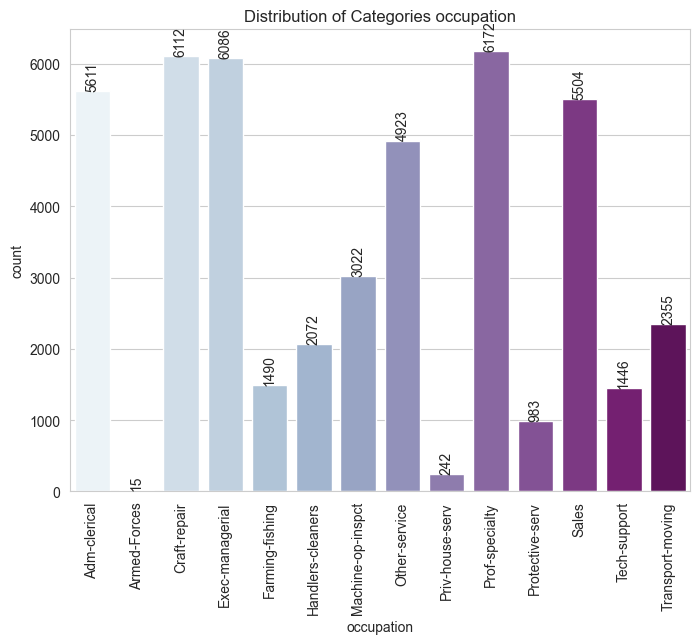

C:\Users\marie\AppData\Local\Temp\ipykernel_15180\2893828428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = column, data=data, palette='BuPu')


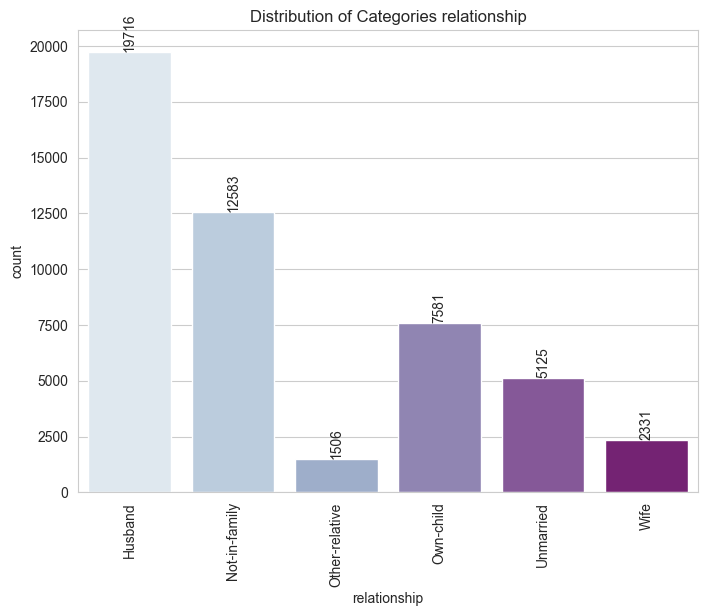

C:\Users\marie\AppData\Local\Temp\ipykernel_15180\2893828428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = column, data=data, palette='BuPu')


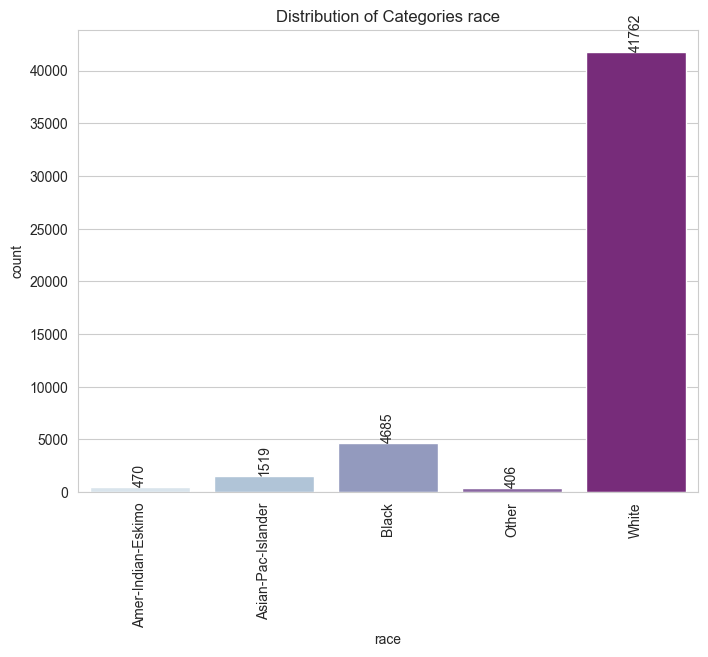

C:\Users\marie\AppData\Local\Temp\ipykernel_15180\2893828428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = column, data=data, palette='BuPu')


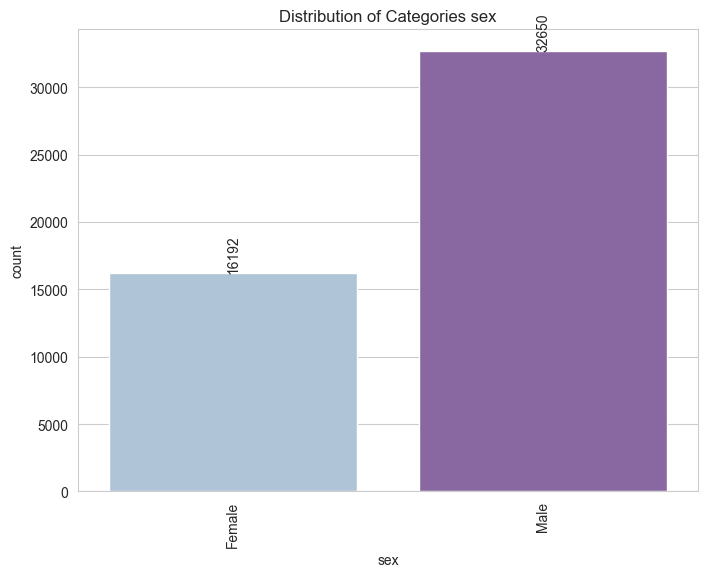

C:\Users\marie\AppData\Local\Temp\ipykernel_15180\2893828428.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = column, data=data, palette='BuPu')


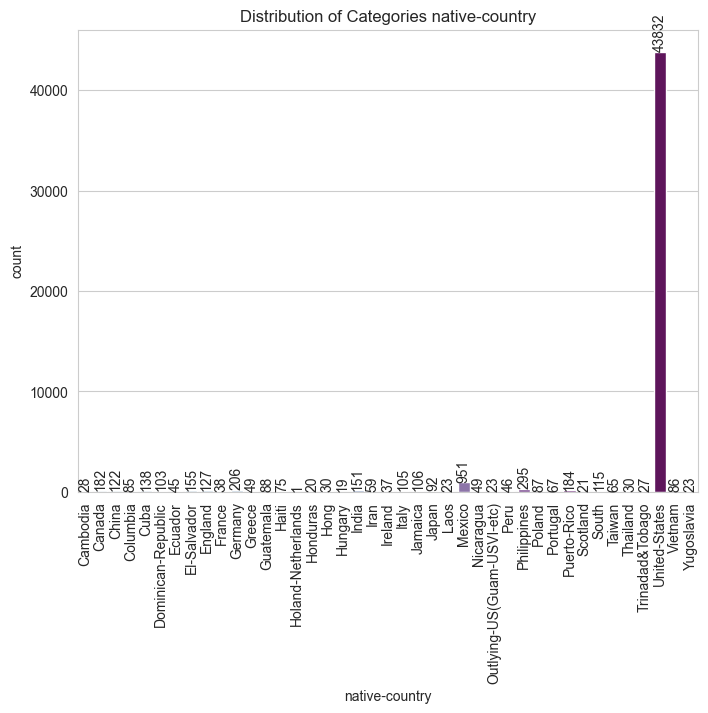

In [15]:
plot_categorical_distribution(data, categorical_features)

### Note
- Since the majority of the data is from the United States, grouping all other countries into a single "Others" category reduces the complexity of handling numerous country categories, many of which have very few entries.
- Similarly, in the Education column, grouping education levels into broader and cleaner categories will help reduce data complexity

In [16]:
# Grouping the Eduction Columnn to simplify analysis by reducing the number of unique categories
data['education'].replace(['1st-4th', '5th-6th'], 'Primary', inplace=True)
data['education'].replace(['7th-8th', '9th', '10th', '11th', '12th'], 'Middle-School', inplace=True)
data['education'].replace(['HS-grad'], 'High-School', inplace=True)
data['education'].replace(['Some-college', 'Assoc-voc', 'Assoc-acdm'], 'College', inplace=True)
data['education'].replace(['Bachelors'], 'Bachelors', inplace=True)
data['education'].replace(['Prof-school', 'Doctorate'], 'Doctorate', inplace=True)

# Grouping the Native Country column, all values that are not 'United-states' with 'Others'
data['native-country'] = data['native-country'].cat.add_categories('Others')
data['native-country'].loc[data['native-country'] != 'United-States'] = 'Others'
data['native-country'] = data['native-country'].cat.remove_unused_categories()

C:\Users\marie\AppData\Local\Temp\ipykernel_15180\1452537554.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['education'].replace(['1st-4th', '5th-6th'], 'Primary', inplace=True)
C:\Users\marie\AppData\Local\Temp\ipykernel_15180\1452537554.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data['education'

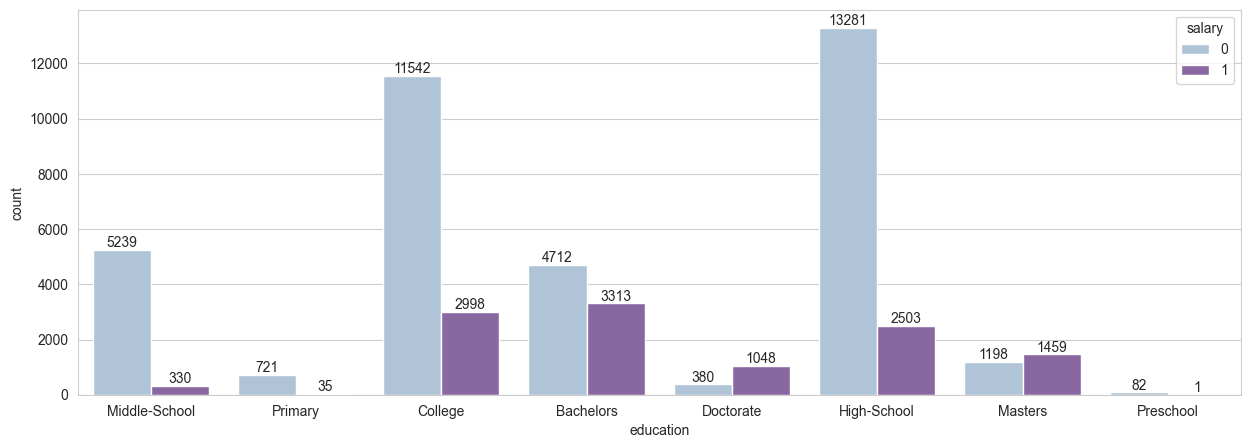

In [17]:
plot_category(data, 'education')

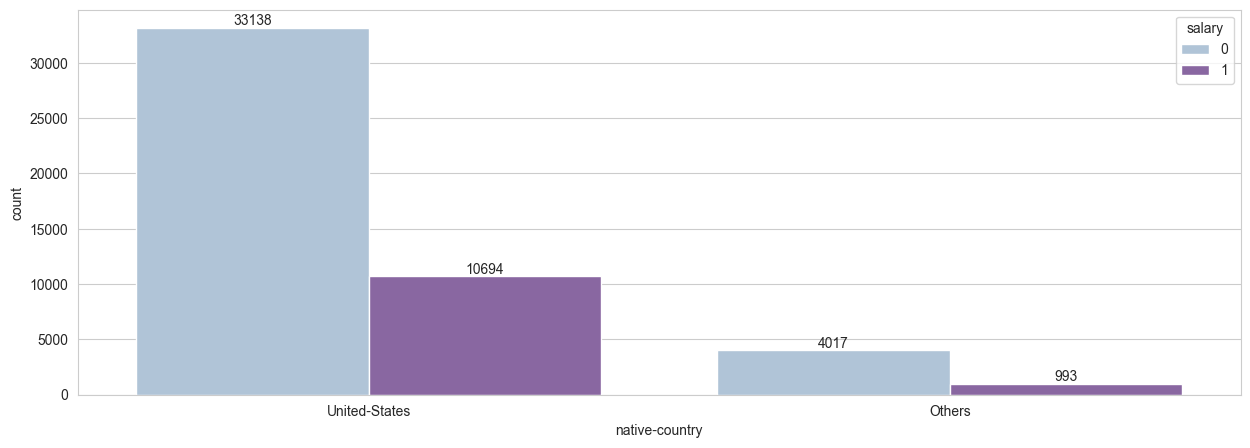

In [18]:
plot_category(data, 'native-country')

In [19]:
data.shape

(48842, 15)

In [20]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,High-School,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,Middle-School,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Others,0


In [21]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [22]:
numerical_features

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [23]:
#Checking the order in which the categories in education are stored
print(data['education'].cat.categories)

Index(['Middle-School', 'Primary', 'College', 'Bachelors', 'Doctorate',
       'High-School', 'Masters', 'Preschool'],
      dtype='object')


In [24]:
#Since the order in education is not correct, it first needs to be set in the correct order 
education_order = ['Preschool', 'Primary', 'Middle-School', 'High-School', 'College', 'Bachelors', 'Masters', 'Doctorate']
data['education'] = pd.Categorical(data['education'], categories=education_order, ordered=True)
print(data['education'].cat.categories)

Index(['Preschool', 'Primary', 'Middle-School', 'High-School', 'College',
       'Bachelors', 'Masters', 'Doctorate'],
      dtype='object')


In [25]:
ordinal_categories = ['education']
onehot_categories = categorical_features.drop('education')

In [26]:
#Make sure there are no missing values in the test datasets and no filled in values, to get the most reliable performance score
clean_data = data.dropna(axis=0, how='any')
test_size = int(data.shape[0] * 0.2)
percentage_y_of_CleanData = test_size/ clean_data.shape[0]

missing_data = data[data.isna().any(axis=1)]
X_missing = missing_data.drop('salary', axis=1)
y_missing = missing_data['salary']

In [27]:
# Split the data into training and test sets
X_clean = clean_data.drop('salary', axis=1)
y_clean = clean_data['salary']

X_train_missing_NaN, X_test, y_train_missing_NaN, y_test = train_test_split(X_clean, y_clean, test_size=percentage_y_of_CleanData, random_state=42)
X_train = pd.concat([X_train_missing_NaN, X_missing], axis=0)
y_train = pd.concat([y_train_missing_NaN, y_missing], axis=0)

In [28]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categoric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categoric_transformer, onehot_categories),
        ('ord', ordinal_transformer, ordinal_categories)
    ]
)

In [29]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [30]:
X_train_transformed.shape, X_test_transformed.shape

((39074, 53), (9768, 53))

In [31]:
features = preprocessor.get_feature_names_out()

# Get transformed dataframe for X_train
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, columns=features, index=X_train.index)
X_train_df.head()

,num__age,num__fnlwgt,num__education-num,num__capital-gain,num__capital-loss,num__hours-per-week,cat__workclass_Federal-gov,cat__workclass_Local-gov,cat__workclass_Never-worked,cat__workclass_Private,...,cat__race_Amer-Indian-Eskimo,cat__race_Asian-Pac-Islander,cat__race_Black,cat__race_Other,cat__race_White,cat__sex_Female,cat__sex_Male,cat__native-country_Others,cat__native-country_United-States,ord__education
12106,0.219178,0.109522,0.6,0,0,0.112245,0,0,0,0,...,0,0,0,0,1.0,0,1.0,0,1.0,1.0
45708,0.287671,0.105906,0.6,0,0,0.346939,0,0,0,0,...,0,0,0,0,1.0,0,1.0,0,1.0,1.0
33338,0.191781,0.196462,0.533333,0,0,0.602041,0,0,0,1.0,...,0,0,0,0,1.0,0,1.0,0,1.0,3.0
10900,0.178082,0.147998,0.666667,0,0,0.397959,0,0,0,0,...,0,0,0,0,1.0,0,1.0,0,1.0,1.0
31949,0.410959,0.124992,0.8,0,0,0.5,1.0,0,0,0,...,0,0,0,0,1.0,0,1.0,0,1.0,0


In [32]:
# Get transformed dataframe for X_test
X_test_df = pd.DataFrame.sparse.from_spmatrix(X_test_transformed, columns=features, index=X_test.index)
X_test_df.head()

,num__age,num__fnlwgt,num__education-num,num__capital-gain,num__capital-loss,num__hours-per-week,cat__workclass_Federal-gov,cat__workclass_Local-gov,cat__workclass_Never-worked,cat__workclass_Private,...,cat__race_Amer-Indian-Eskimo,cat__race_Asian-Pac-Islander,cat__race_Black,cat__race_Other,cat__race_White,cat__sex_Female,cat__sex_Male,cat__native-country_Others,cat__native-country_United-States,ord__education
17735,0.123288,0.234549,0.6,0,0,0.5,0,0,0,1.0,...,0,0,0,0,1.0,1.0,0,1.0,0,1.0
40368,0.287671,0.011131,0.6,0,0,0.397959,0,0,0,1.0,...,0,0,0,0,1.0,1.0,0,0,1.0,1.0
44809,0.589041,0.18535,0.533333,0,0,0.397959,1.0,0,0,0,...,0,0,0,0,1.0,0,1.0,0,1.0,3.0
39139,0.054795,0.175867,0.6,0,0,0.346939,0,0,0,1.0,...,0,0,0,0,1.0,0,1.0,0,1.0,1.0
15918,0.506849,0.145826,0.6,0,0,0.397959,0,0,0,1.0,...,0,0,0,0,1.0,0,1.0,0,1.0,1.0


C:\Users\marie\AppData\Local\Temp\ipykernel_15180\2964243254.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = corr_by_income.index, x = corr_by_income, palette='BuPu')


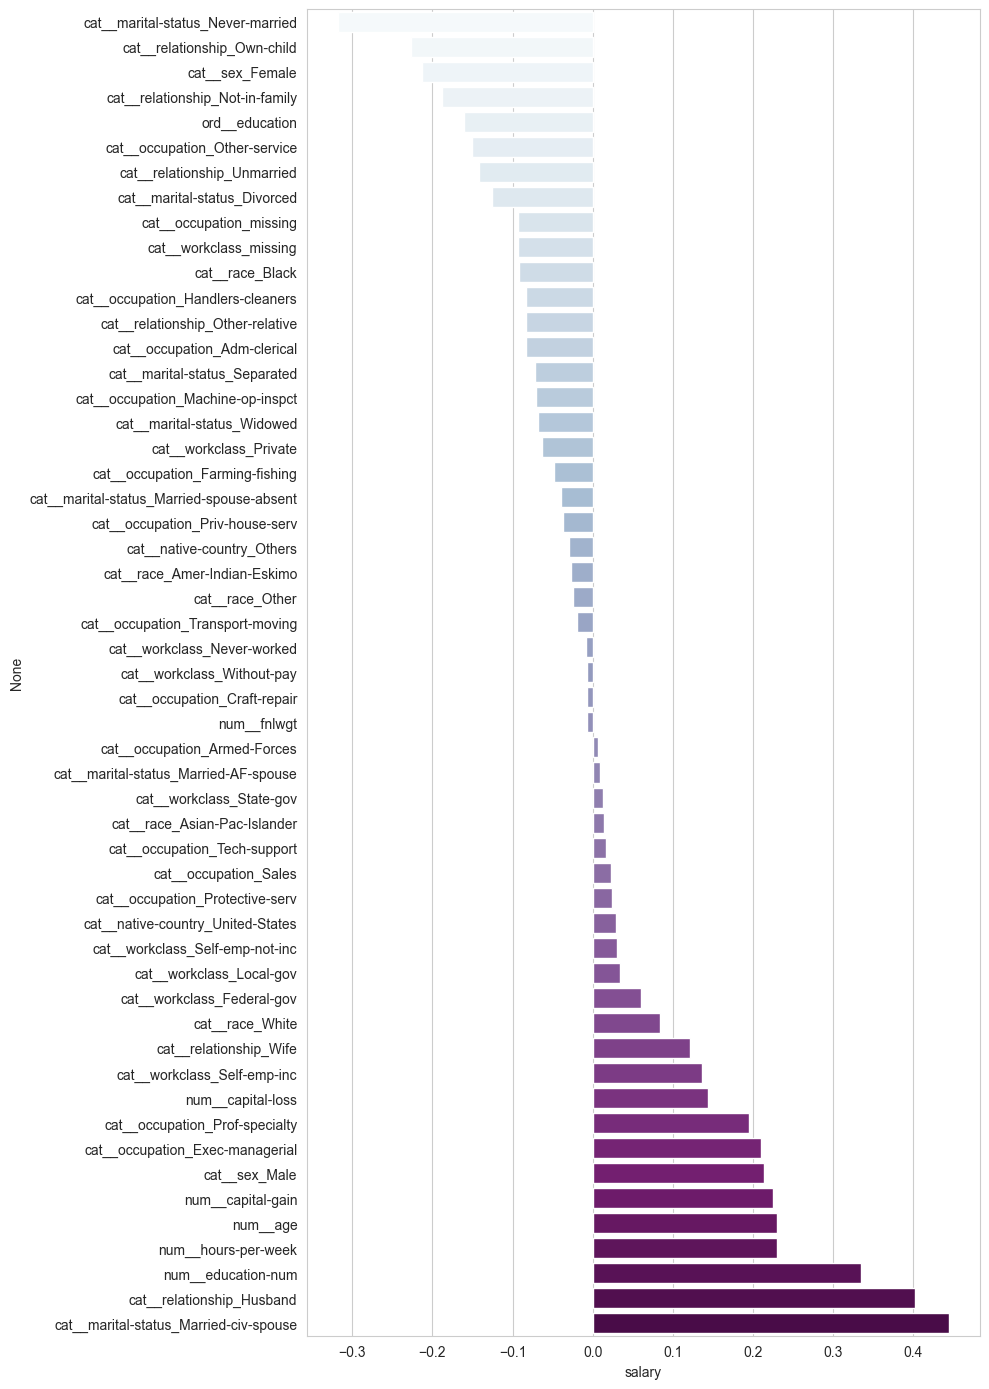

In [33]:
# Get correlation with Salary
corr_by_income = X_train_df.join(y_train).corr()["salary"].sort_values()[:-1]

# Plot so that you can also see the magnitude of the correlation
plt.figure(figsize = (10, 14))
sns.barplot(y = corr_by_income.index, x = corr_by_income, palette='BuPu')
plt.tight_layout()

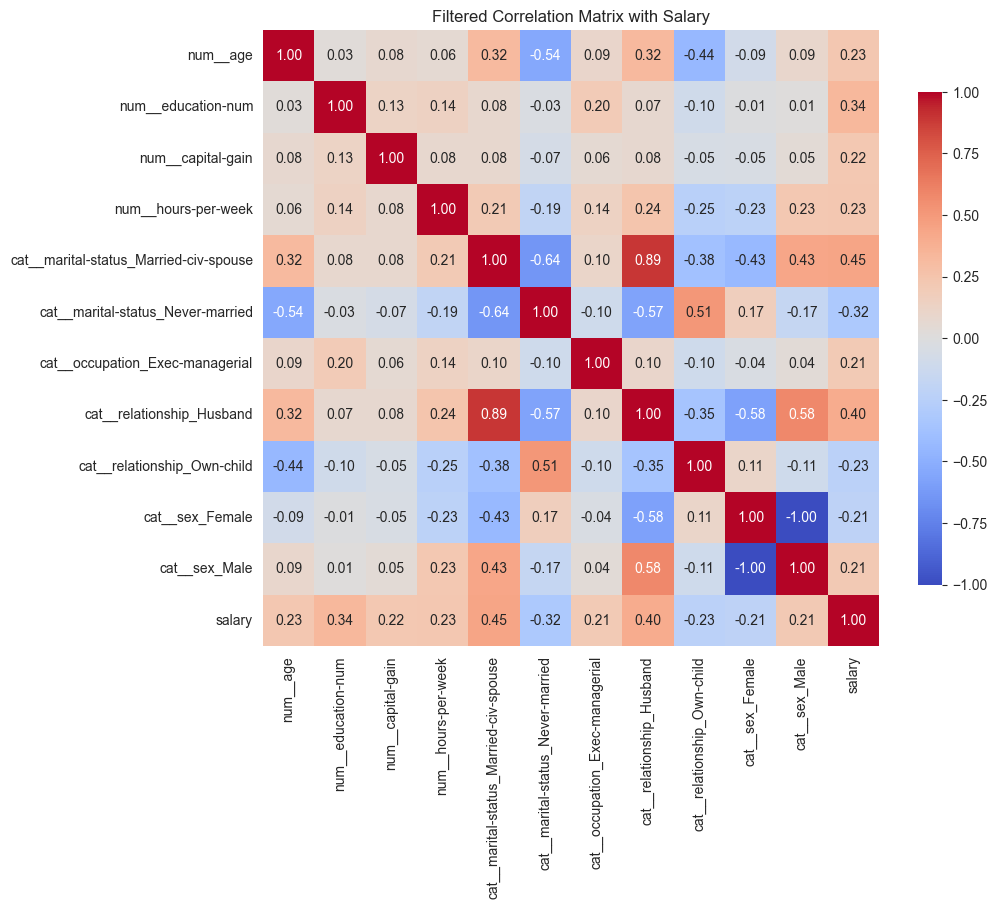

In [34]:
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)

combined_train_df = pd.concat([X_train_df.reset_index(drop=True), y_train_df], axis=1)
combined_train_df.rename(columns={combined_train_df.columns[-1]: 'salary'}, inplace=True)

correlation_matrix = combined_train_df.corr()

# Set a correlation threshold, I have chosen 0.2 here based on the plot above.
threshold = 0.2

abs_corr = correlation_matrix['salary'].abs()
high_corr_features = abs_corr[abs_corr > threshold].index
filtered_corr_matrix = combined_train_df[high_corr_features].corr()

# Plot the heatmap for highest correlation features with salary
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Filtered Correlation Matrix with Salary')
plt.show()

### After finding the features which have a high correlation with salary, now remove all the features that have a high correlation among each other or a low one with salary

In [35]:
# Step 1: Calculate absolute correlations with the target variable 'salary'
abs_corr_with_salary = combined_train_df.corr()['salary'].abs()

# Step 2: Create a mask for features that have low correlation with 'salary'
low_corr_mask = abs_corr_with_salary < 0.15

# Step 3: Create a mask for high correlations among features
high_corr_mask = (filtered_corr_matrix.abs() > 0.5) & (filtered_corr_matrix != 1)

# Step 4: Initialize a set to keep track of features to drop
features_to_drop = set()

# Step 5: Identify features to drop based on high correlations
high_corr = []
for i in range(len(filtered_corr_matrix.columns)):
    for j in range(i):
        if high_corr_mask.iloc[i, j] and filtered_corr_matrix.columns[i] != 'salary' and filtered_corr_matrix.columns[j] != 'salary':
            high_corr.append((filtered_corr_matrix.columns[i], filtered_corr_matrix.columns[j], 
                              filtered_corr_matrix[filtered_corr_matrix.columns[i]][filtered_corr_matrix.columns[j]]))
high_corr_sorted = sorted(high_corr, key=lambda x: abs(x[2]), reverse=True)
for feature1, feature2, correlation in high_corr_sorted:
    if abs_corr_with_salary[feature1] <= abs_corr_with_salary[feature2]:
        features_to_drop.add(feature1)

# Step 6: Add features with low correlation to the target variable
low_corr_features = abs_corr_with_salary[low_corr_mask].index.tolist()
features_to_drop.update(low_corr_features)

# Step 7: Convert set to list for easier handling
features_to_drop = list(features_to_drop)

# Step 8: Display the features to drop
print("Features to drop:", features_to_drop)

# Step 9: Drop the selected features from the original DataFrame
X_train_reduced = X_train_df.drop(columns=features_to_drop)
X_test_reduced = X_test_df.drop(columns=features_to_drop)

# Step 10: Verify the shapes of the new DataFrames
print("New X_train shape:", X_train_reduced.shape)
print("New X_test shape:", X_test_reduced.shape)

Features to drop: ['cat__marital-status_Married-spouse-absent', 'num__capital-loss', 'cat__sex_Male', 'cat__occupation_Farming-fishing', 'cat__race_Other', 'cat__relationship_Wife', 'cat__workclass_Private', 'cat__race_White', 'cat__relationship_Unmarried', 'cat__relationship_Other-relative', 'cat__workclass_Without-pay', 'cat__occupation_Transport-moving', 'cat__occupation_Handlers-cleaners', 'cat__occupation_Machine-op-inspct', 'cat__marital-status_Never-married', 'cat__occupation_Protective-serv', 'cat__relationship_Husband', 'cat__occupation_Tech-support', 'cat__occupation_Priv-house-serv', 'cat__workclass_missing', 'cat__occupation_missing', 'cat__marital-status_Widowed', 'cat__marital-status_Separated', 'num__fnlwgt', 'cat__workclass_Never-worked', 'cat__marital-status_Divorced', 'cat__relationship_Own-child', 'cat__race_Asian-Pac-Islander', 'cat__native-country_United-States', 'cat__sex_Female', 'cat__workclass_Self-emp-not-inc', 'cat__occupation_Sales', 'cat__occupation_Adm-cle

In [36]:
X_train_reduced.head()

,num__age,num__education-num,num__capital-gain,num__hours-per-week,cat__marital-status_Married-civ-spouse,cat__occupation_Exec-managerial,cat__occupation_Other-service,cat__occupation_Prof-specialty,cat__relationship_Not-in-family,ord__education
12106,0.219178,0.6,0,0.112245,0,0,0,0,1.0,1.0
45708,0.287671,0.6,0,0.346939,1.0,0,0,0,0,1.0
33338,0.191781,0.533333,0,0.602041,0,0,0,0,1.0,3.0
10900,0.178082,0.666667,0,0.397959,1.0,0,0,0,0,1.0
31949,0.410959,0.8,0,0.5,1.0,0,0,1.0,0,0


In [37]:
X_train_reduced.shape, X_test_reduced.shape, y_train.shape, y_test.shape

((39074, 10), (9768, 10), (39074,), (9768,))

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def apply_model(model, X_train, X_test, y_train, y_test, steps=None):
    # Convert sparse matrix to dense format for models that do not support sparse input
    if hasattr(X_train, "toarray"):  # Check if X_train is sparse
        X_train = X_train.toarray()
        X_test = X_test.toarray()
        
    if steps is not None:
        ct = ColumnTransformer(transformers=steps)
        pipeline = Pipeline(steps=[('transformer', ct), 
                                   ('model', model)])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Apply models and collect results
results_lr = apply_model(LogisticRegression(max_iter=500), X_train_reduced, X_test_reduced, y_train, y_test) 
results_rf = apply_model(RandomForestClassifier(n_estimators=100, n_jobs=-1), X_train_reduced, X_test_reduced, y_train, y_test)
results_gbm = apply_model(GradientBoostingClassifier(n_estimators=100), X_train_reduced, X_test_reduced, y_train, y_test)
results_nb = apply_model(MultinomialNB(), X_train_reduced, X_test_reduced, y_train, y_test)

# Print the results
print("Results from Logistic Regression:")
print("Accuracy:", results_lr[0])
print("Precision:", results_lr[1])
print("Recall:", results_lr[2])
print("F1 Score:", results_lr[3])
print("\n")

print("Results from Random Forest Classifier:")
print("Accuracy:", results_rf[0])
print("Precision:", results_rf[1])
print("Recall:", results_rf[2])
print("F1 Score:", results_rf[3])
print("\n")

print("Results from Gradient Boosting Classifier:")
print("Accuracy:", results_gbm[0])
print("Precision:", results_gbm[1])
print("Recall:", results_gbm[2])
print("F1 Score:", results_gbm[3])
print("\n")

print("Results from Naive Bayes Classifier:")
print("Accuracy:", results_nb[0])
print("Precision:", results_nb[1])
print("Recall:", results_nb[2])
print("F1 Score:", results_nb[3])
print("\n")

Results from Logistic Regression:
Accuracy: 0.8355855855855856
Precision: 0.7124802527646129
Recall: 0.5607128056361376
F1 Score: 0.6275510204081632


Results from Random Forest Classifier:
Accuracy: 0.823914823914824
Precision: 0.6658688367640019
Recall: 0.5764608371322005
F1 Score: 0.6179475788538428


Results from Gradient Boosting Classifier:
Accuracy: 0.852989352989353
Precision: 0.7586024351508734
Recall: 0.593866556154165
F1 Score: 0.6662017666201767


Results from Naive Bayes Classifier:
Accuracy: 0.7988329238329238
Precision: 0.6686746987951807
Recall: 0.3680066307501036
F1 Score: 0.4747393744987971




### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [40]:
def perturbate(y: np.ndarray, fraction: float) -> np.ndarray:
    perturbed_y = y.copy()
    random_indices = perturbed_y.sample(n=int(fraction * len(perturbed_y)), random_state=1).index
    for i in random_indices:
        perturbed_y[i] = 1 - perturbed_y[i]
    return perturbed_y

#### Evaluate Models

In [41]:
from sklearn.svm import SVC
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Naive Bayes': MultinomialNB()
}

In [42]:
def evaluate_models_on_perturbed_data(X_train, X_test, y_train, y_test, models, n_runs=1):
    results = {}
    
    for model_name, model in models.items():
        results[model_name] = {
            'original': [],
            'perturbed_0.1': [],
            'perturbed_0.2': [],
            'perturbed_0.3': [],
            'perturbed_0.4': [],
            'perturbed_0.5': []
        }
        
        for _ in range(n_runs):
            # Original f1 score
            f1_score = apply_model(model, X_train, X_test, y_train, y_test)[3]
            results[model_name]['original'].append(f1_score)
            
            # Perturbed f1 scores
            for fraction in [0.1, 0.2, 0.3, 0.4, 0.5]:
                perturbed_y = perturbate(y_train, fraction)
                perturbed_f1_score = apply_model(model, X_train, X_test, perturbed_y, y_test)[3]
                results[model_name][f'perturbed_{fraction}'].append(perturbed_f1_score)

    # Calculate mean and variance for each model and perturbation level
    for model_name, metrics in results.items():
        for key in metrics:
            metrics[key] = (np.mean(metrics[key]), np.var(metrics[key]))
    
    return results

In [43]:
def visualize_results(results):
    perturbation_levels = ['original', 'perturbed_0.1', 'perturbed_0.2', 'perturbed_0.3', 'perturbed_0.4', 'perturbed_0.5']
    
    plt.figure(figsize=(12, 6))

    for model_name, metrics in results.items():
        f1_scores = [metrics[key][0] for key in perturbation_levels]  # Get mean f1 score
        variances = [metrics[key][1] for key in perturbation_levels]    # Get variance

        # Calculate standard deviation for error bars
        std_devs = np.sqrt(variances)

        plt.errorbar(perturbation_levels, f1_scores, yerr=std_devs, label=model_name, capsize=5, marker='o')
        
        for i, (x, y) in enumerate(zip(perturbation_levels, f1_scores)):
            plt.text(i, y, f'{y:.3f}', ha='center', va='bottom', fontsize=10)

    plt.title('Model Performance on Perturbed Data')
    plt.xlabel('Perturbation Level')
    plt.ylabel('f1 score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

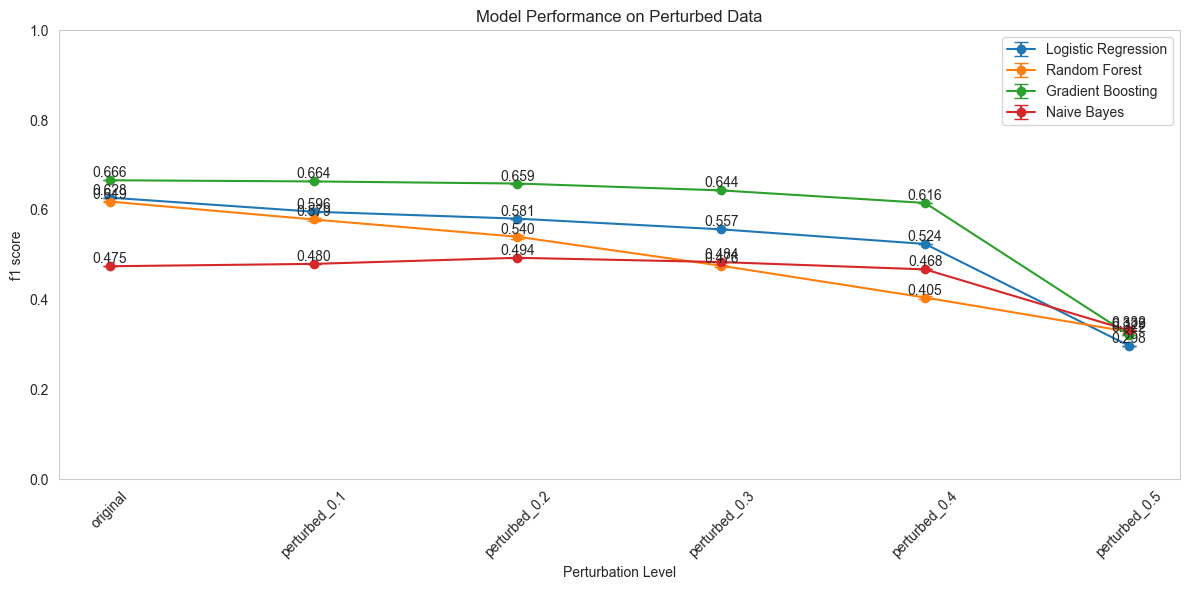

In [44]:
results = evaluate_models_on_perturbed_data(X_train_reduced, X_test_reduced, y_train, y_test, models, n_runs=5)

# Visualize the results
visualize_results(results)

#### Visualizing results

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

Now we have a some datasets that are related to each other.

**Altogether they are the same as the adult dataset used in the part 1 of the assignment.**

In this scenario, one can see the utility of the subsets of data can impact the outcome of the task from the previous section.

Because the data is split up, we want to be able to re-construct the data through data discovery.

As data discovery will allow you to be able to find relations that can be used to reconstruct the entire dataset.

Implement a method of your choice to perform the data discovery to be able to recover the entire dataset from part 1 of the assignment.

In [45]:
def convert_features(dataset):
    for column in dataset.columns:
        if column in ["last_names", "first_name"]:
            dataset.drop(column, axis=1)
        elif column == "salary":
            dataset.loc[dataset['salary'] == '>50K', 'salary'] = 1
            dataset.loc[dataset['salary'] == '>50K.', 'salary'] = 1
            dataset.loc[dataset['salary'] == '<=50K', 'salary'] = 0
            dataset.loc[dataset['salary'] == '<=50K.', 'salary'] = 0
            dataset[column] = dataset[column].astype("int64")
        elif dataset[column].dtype == object:
            dataset[column] = dataset[column].astype("category")
            
def handle_NaN_values(dataset):
    numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = dataset.select_dtypes(include=['category', 'object']).columns

    if len(numerical_features) > 0:
        num_imputer = SimpleImputer(strategy='median')
        dataset[numerical_features] = num_imputer.fit_transform(dataset[numerical_features])
    
    if len(categorical_features) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        dataset[categorical_features] = cat_imputer.fit_transform(dataset[categorical_features])

def encoding_scaling(dataset):
    numerical_features = dataset.select_dtypes(include='int64').columns
    categorical_features = dataset.select_dtypes(include='category').columns
    
    numerical_features = numerical_features.drop('salary', errors='ignore')
    categorical_features = categorical_features.drop('salary', errors='ignore')
    
    steps = [
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features), 
    ]
    
    # Combine steps into a ColumnTransformer
    ct = ColumnTransformer(transformers=steps)
    X_transformed_withoutNames = ct.fit_transform(dataset)
    new_cat_features = ct.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = list(numerical_features) + new_cat_features.tolist()
    X_transformed = pd.DataFrame(X_transformed_withoutNames.toarray(), columns=feature_names)
    return X_transformed

In [46]:
class FoundJoin(Exception): pass
class FoundUnion(Exception): pass

def discovery_algorithm(datasets):
    """Function should be able to perform data discovery to find related datasets
    Possible Input: List of datasets
    Output: List of pairs of related datasets
    """
    return join_algorithm(union_algorithm(datasets))

def join_algorithm(datasets, skip_datasets=None):
    """
    Algorithm that finds all datasets that are compatibly by join and returns
    a combined dataset.
    :param datasets: array of input datasets
    :param skip_datasets: indices of any dataset to skip
    :return: array of combined datasets
    """
    resulting_datasets = []
    skipped_datasets = []
    len_datasets = len(datasets)
    
    # Remove datasets that we don't want to union:
    if skip_datasets is not None:
        for to_skip in skip_datasets:
            skipped_datasets.append(datasets.remove(to_skip))
            
    for idx, dataset_1 in enumerate(datasets):
        # For each dataset, try to find another dataset to join on:
        merged_dataset = None
        try:
            for idx_2, dataset_2 in enumerate(datasets[idx + 1:]):
                for column_1 in dataset_1.columns:
                    for column_2 in dataset_2.columns:
                        if dataset_1[column_1].equals(dataset_2[column_2]):
                            merged_dataset = pd.merge(dataset_1, dataset_2, left_on=column_1, right_on=column_2)
                            datasets.pop(idx_2)
                            raise FoundJoin(dataset_2)
                        
        # We found a dataset with a column we can join on, 
        # add the merged dataset to resulting_datasets.
        except FoundJoin:
            resulting_datasets.append(merged_dataset)
            
        # Cannot find any dataset to join on, 
        # add the unmerged dataset to resulting_datasets.
        else:
            resulting_datasets.append(dataset_1)

    # Recursively check if we can merge further, only if we merged
    # datasets in this iteration.
    if len(resulting_datasets) == len_datasets:
        for skipped_dataset in skipped_datasets:
            resulting_datasets.append(skipped_dataset)

        return resulting_datasets
    else:
        recursion = join_algorithm(resulting_datasets)
        for skipped_dataset in skipped_datasets:
            recursion.append(skipped_dataset)

        return recursion
                        
def union_algorithm(datasets, skip_datasets=None, minimal_intersection=0.4):
    """
    Algorithm that finds all datasets that are compatibly by union and returns
    a combined dataset.
    :param datasets: array of input datasets
    :param skip_datasets: indices of any dataset to skip
    :param minimal_intersection: minimal percentage of headers that need to overlap
    to perform a union
    :return: array of combined datasets
    """
    resulting_datasets = []
    skipped_datasets = []
    len_datasets = len(datasets)
    
    # Remove datasets that we don't want to union:
    if skip_datasets is not None:
        for to_skip in skip_datasets:
            skipped_datasets.append(datasets.remove(to_skip))
    
    for idx, dataset_1 in enumerate(datasets):
        # For each dataset, try to find another dataset to union on:
        concatenated_dataset = None
        try:
            for idx_2, dataset_2 in enumerate(datasets[idx + 1:]):
                union_columns = len(set(dataset_1.columns).union(set(dataset_2.columns)))
                intersection_columns = len(set(dataset_1.columns).intersection(set(dataset_2.columns)))
                
                # If columns are minimally intersecting by minimal_intersection,
                # we can union the two datasets.
                if intersection_columns > union_columns * minimal_intersection:
                    concatenated_dataset = pd.concat([dataset_1, dataset_2])
                    datasets.pop(idx_2)
                    raise FoundUnion
                        
        # We found a dataset with a column we can join on, 
        # add the merged dataset to resulting_datasets.
        except FoundUnion:
            resulting_datasets.append(concatenated_dataset)
            datasets.pop(idx)
            
        # Cannot find any dataset to join on, 
        # add the unmerged dataset to resulting_datasets.
        else:
            resulting_datasets.append(dataset_1)
            

    if len(resulting_datasets) == len_datasets:
        for skipped_dataset in skipped_datasets:
            resulting_datasets.append(skipped_dataset)

        return resulting_datasets
    else:
        recursion = union_algorithm(resulting_datasets, minimal_intersection=minimal_intersection)
        for skipped_dataset in skipped_datasets:
            recursion.append(skipped_dataset)

        return recursion

def grab_data(x=3, y=2):
    """
    :param x: first digit of csv
    :param y: second digit of csv
    :return: array with all datasets
    """
    data_array = []
    for current_x in range(0, x):
        for current_y in range(1, y + 1):
            data_array.append(pd.read_csv(
                f"data_adult_discovery/data_adult_{current_x}_{current_y}.csv", na_values='?').copy())
    return data_array
    
split_data = grab_data()
combined_data = discovery_algorithm(split_data.copy())

print("Shape uncombined dataset(s):")
for i in split_data:
    print(i.shape)
    
print("Shape combined dataset(s):")
for i in combined_data:
    print(i.shape)

Shape uncombined dataset(s):
(16281, 11)
(16281, 10)
(16281, 11)
(16281, 10)
(16280, 11)
(16280, 10)
Shape combined dataset(s):
(65123, 18)


In [47]:
# Change the index if you want to train on different dataset in the array.
combined_dataset = combined_data[0].copy()
combined_dataset = combined_dataset.drop('Unnamed: 0', axis=1).drop("first_name", axis=1).drop("last_names", axis=1)
handle_NaN_values(combined_dataset)
convert_features(combined_dataset)

combined_dataset

,hours-per-week,occupation,capital-gain,relationship,education-num,sex,workclass,capital-loss,marital-status,salary,native-country,age,fnlwgt,education,race
0,20.0,Other-service,0.0,Not-in-family,9.0,Male,Private,0.0,Married-civ-spouse,0,United-States,37.0,178222.0,HS-grad,White
1,20.0,Sales,0.0,Own-child,8.0,Female,Private,0.0,Married-civ-spouse,0,United-States,37.0,178222.0,HS-grad,White
2,40.0,Handlers-cleaners,0.0,Other-relative,9.0,Male,Local-gov,0.0,Married-civ-spouse,0,United-States,37.0,178222.0,HS-grad,White
3,30.0,Sales,0.0,Own-child,10.0,Female,Private,0.0,Married-civ-spouse,0,United-States,37.0,178222.0,HS-grad,White
4,56.0,Machine-op-inspct,0.0,Unmarried,9.0,Male,Private,0.0,Married-civ-spouse,0,United-States,37.0,178222.0,HS-grad,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,40.0,Exec-managerial,0.0,Husband,13.0,Male,Private,1887.0,Married-civ-spouse,0,United-States,37.0,200117.0,HS-grad,White
16276,40.0,Machine-op-inspct,0.0,Own-child,9.0,Male,Private,0.0,Never-married,0,United-States,37.0,90896.0,HS-grad,White
16277,40.0,Adm-clerical,0.0,Not-in-family,9.0,Male,Private,0.0,Divorced,0,United-States,37.0,370057.0,HS-grad,White
16278,40.0,Adm-clerical,0.0,Own-child,7.0,Male,Private,0.0,Never-married,0,United-States,37.0,216284.0,HS-grad,White


In [48]:
combined_dataset.dtypes

hours-per-week     float64
occupation        category
capital-gain       float64
relationship      category
education-num      float64
sex               category
workclass         category
capital-loss       float64
marital-status    category
salary               int64
native-country    category
age                float64
fnlwgt             float64
education         category
race              category
dtype: object

In [49]:
def get_test_data():
    """
    Get the ground truth data to test with from the adult.csv dataset.

    Returns:
    X_test_adult (DataFrame): The feature matrix for the test data.
    y_test_adult (Series): The target variable for the test data.
    """
    # data refers to the inital loaded adult.csv dataset
    X_adult = data.copy().drop('salary', axis=1)
    y_adult = data.copy()['salary']
    _, X_test_adult, _, y_test_adult = train_test_split(X_adult, y_adult, test_size=0.2, random_state=6)
    return X_test_adult, y_test_adult

def run_models_for_combined():
    X_test_adult, y_test_adult = get_test_data()
    
    nf_comb = combined_dataset.drop('salary', axis=1).select_dtypes(include='float64').columns
    cf_comb = combined_dataset.select_dtypes(include='category').columns
    steps_comb = [
        ('num', MinMaxScaler(), nf_comb),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cf_comb), 
    ]

    for i, model_info in enumerate(models.items()):
        model_name, model = model_info
        X_comb = combined_dataset.copy().drop("salary", axis=1)
        y_comb = combined_dataset['salary']
        X_train_comb, _, y_train_comb, _ = train_test_split(X_comb, y_comb, test_size=0.2, random_state=42)

        acc, precision, recall, f1 = apply_model(model, X_train=X_train_comb, X_test=X_test_adult, y_train=y_train_comb, y_test=y_test_adult, steps=steps_comb)
        print(f'Classifier {model_name} \n'
            f'acc: {round(acc, 2)}, precision: {round(precision, 2)}, recall: {round(recall, 2)}, f1: {round(f1, 2)}')
        
run_models_for_combined()

C:\Users\marie\OneDrive\Documenten\Bestanden\Studie\Geomatics\DSAIT4000\Assignment 1\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classifier Logistic Regression 
acc: 0.76, precision: 0.0, recall: 0.0, f1: 0.0
Classifier Random Forest 
acc: 0.76, precision: 0.67, recall: 0.0, f1: 0.0
Classifier Gradient Boosting 
acc: 0.76, precision: 0.0, recall: 0.0, f1: 0.0
Classifier Naive Bayes 
acc: 0.76, precision: 0.62, recall: 0.01, f1: 0.03


C:\Users\marie\OneDrive\Documenten\Bestanden\Studie\Geomatics\DSAIT4000\Assignment 1\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
def get_datasets_with_salary(x=3, y=2):
    """
    :param x: first digit of csv
    :param y: second digit of csv
    :return: array with all datasets
    """
    data_array = []
    for current_x in range(0, x):
        for current_y in range(1, y + 1):
            ds = pd.read_csv(f"data_adult_discovery/data_adult_{current_x}_{current_y}.csv", na_values='?').copy()
            if "salary" in ds:
                data_array.append(ds)
    return data_array

def run_models_for_seperate():
    for ds in get_datasets_with_salary():
        print(f'Working on dataset with shape {ds.shape}...')

        handle_NaN_values(ds)
        convert_features(ds)

        for i, model_info in enumerate(models.items()):
            model_name, model = model_info
            X_seperate = encoding_scaling(ds.drop("salary", axis=1))
            y_seperate = ds['salary']
            X_seperate_train, X_seperate_test, y_seperate_train, y_seperate_test = train_test_split(X_seperate, y_seperate, test_size=0.2, random_state=42)
            acc, precision, recall, f1 = apply_model(model, X_seperate_train, X_seperate_test, y_seperate_train, y_seperate_test)
            print(f'Classifier {model_name} \n'
                f'acc: {round(acc, 2)}, precision: {round(precision, 2)}, recall: {round(recall, 2)}, f1: {round(f1, 2)}')
            
run_models_for_seperate()

Working on dataset with shape (16281, 10)...
Classifier Logistic Regression 
acc: 0.81, precision: 0.66, recall: 0.38, f1: 0.48
Classifier Random Forest 
acc: 0.8, precision: 0.64, recall: 0.38, f1: 0.48
Classifier Gradient Boosting 
acc: 0.8, precision: 0.67, recall: 0.35, f1: 0.46
Classifier Naive Bayes 
acc: 0.8, precision: 0.66, recall: 0.35, f1: 0.45
Working on dataset with shape (16281, 11)...
Classifier Logistic Regression 
acc: 0.82, precision: 0.63, recall: 0.59, f1: 0.61
Classifier Random Forest 
acc: 0.81, precision: 0.62, recall: 0.6, f1: 0.61
Classifier Gradient Boosting 
acc: 0.82, precision: 0.66, recall: 0.51, f1: 0.58
Classifier Naive Bayes 
acc: 0.77, precision: 0.51, recall: 0.8, f1: 0.62
Working on dataset with shape (16280, 10)...
Classifier Logistic Regression 
acc: 0.79, precision: 0.75, recall: 0.18, f1: 0.29
Classifier Random Forest 
acc: 0.79, precision: 0.74, recall: 0.18, f1: 0.29
Classifier Gradient Boosting 
acc: 0.79, precision: 0.76, recall: 0.17, f1: 0.

### Evaluation

Following the same workflow as Part 1 of the assignment, you will need to perform the steps once again.
This means that with the difference in setting, there has now been a change in the data loading portion of the workflow. 

<!-- While performing data discovery, one can check how having more data of different relations can effect the outcome of the downstream task. -->

As you perform the act of data discovery you will be piecing the data back together one by one by finding the relation between the datasets.

As you piece the data back together, the entire dataset will be available in varying portions.

Then using the different portions of available data, fit the models that were used previously, and examine the results when testing on the appropriate data from the testing samples.

*The dataset from part 1 can be treated as the groundtruth, so you can try and random sample from that dataset to produce the testing samples that can be used in this part.* 

***

One can also evaluate on the effect of incorrectness of data discovery.

Suppose what you have done for data discovery is correct, this means the relations that are found are correct.

What if you perform a perturbation on the relations between the files? 

This would mean the dataset will be incorrectly joined, do you think there will be an impact on the outcome of the model that will be trained and then tested on the groudtruth dataset?

What would the effect be on the downstream tasks as mentioned in the machine learning workflow such as data pre-processing, machine learning model training and testing?

This can be evaluated in the same way as above.

In [51]:
## Do some testing on performing various degrees of incorrect data discovery.
##

## Discussions

1)  Discuss the different effects of the results of the data discovery results on various downstream tasks in the machine learning workflow.
    As stated previously, this is effecting the data loading portion of the ML workflow.

2)  Discuss also what aspects need to be considered when performing data discovery and evaluating the results of data discovery.

Max. 400 words

The perturbations that performed for part 1 and 2 are all data quality issues.

3) Discuss on the effects of data quality and how you may attempt to identify and solve these issues?

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words